In [1]:
%run ../tools/imports.ipynb
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

h = pickle.load(open("../handler.p", "rb"))
def preprocess_cooling(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(3)]
        fitted = False
    else:
        fitted = True
    
    weather = h.get_weather_from_list(epw_files=X.iloc[:,-1] , n_cols=len(h.columns))
    if fitted:
        weather = standardization[0].transform(weather)
        params = standardization[1].transform(X.iloc[:,:-1])
        y = standardization[2].transform(y)
    else:
        weather = standardization[0].fit_transform(weather)
        params = standardization[1].fit_transform(X.iloc[:,:-1])
        y = standardization[2].fit_transform(y)
    
    weather_list=[]
    weather = weather.transpose()
    for i in range(len(X)):
        weather_list.append(weather[:,i*8760:(i+1)*8760].ravel())
    weather = np.array(weather_list)
    
    X = np.hstack((weather, params))
    
    return X, y, standardization

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, X_raw, y_raw, list_IDs, standardizer, batch_size=32, shuffle=True):
        'Initialization'
        self.X_raw = X_raw
        self.y_raw = y_raw
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.standardizer = standardizer
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X, y,_ = np.array(preprocess_cooling(self.X_raw.iloc[list_IDs_temp,:14], self.y_raw.iloc[list_IDs_temp,:], self.standardizer))

        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [3]:
standardizer = pickle.load(open('standardizer_cooling.p','rb'))

In [4]:
from tensorflow.keras.layers import Reshape, Permute, Lambda
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("cv_l2_cooling_3.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
ann = model_from_json(loaded_model_json)
# load weights into new model
ann.load_weights("cv_l2_cooling_3.h5")
print("Loaded model from disk")
ann.compile(optimizer=Adam(lr=1e-3), loss='mse')

W0410 19:48:12.547171 140628087273280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0410 19:48:12.548423 140628087273280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0410 19:48:12.551629 140628087273280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loaded model from disk


Winnipeg        R2 score:    99.32 %, MAPE:   4.41 %, RMSPE:  6.46 %.
Ottawa          R2 score:    99.23 %, MAPE:   3.97 %, RMSPE:  5.29 %.
Longueuil       R2 score:    99.34 %, MAPE:   3.97 %, RMSPE:  5.50 %.
Toronto         R2 score:    98.98 %, MAPE:   4.19 %, RMSPE:  5.82 %.
Taloyoak        R2 score:    87.82 %, MAPE: 574.30 %, RMSPE: 7558.11 %.
Lesage          R2 score:    99.59 %, MAPE:   3.74 %, RMSPE:  5.91 %.
Montreal        R2 score:    99.31 %, MAPE:   4.76 %, RMSPE:  7.10 %.
Norman_Wells    R2 score:    97.22 %, MAPE:  23.39 %, RMSPE: 103.61 %.
Edmonton        R2 score:    98.81 %, MAPE:   9.62 %, RMSPE: 24.68 %.
Victoria        R2 score:    99.05 %, MAPE:   5.90 %, RMSPE: 10.99 %.
Hamilton        R2 score:    99.45 %, MAPE:   3.32 %, RMSPE:  4.50 %.
Halifax         R2 score:    99.27 %, MAPE:   5.57 %, RMSPE: 12.35 %.
London          R2 score:    98.96 %, MAPE:   5.13 %, RMSPE:  7.72 %.
Laval           R2 score:    99.39 %, MAPE:   3.91 %, RMSPE:  5.46 %.
Calgary         R

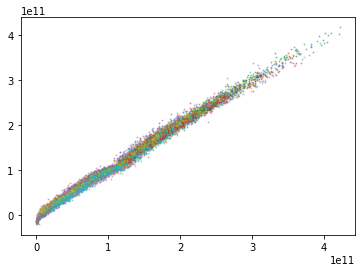

In [5]:
%%time
y_pred_list=[]
y_true_list=[]
scores = np.ndarray((20,3))
for i, city in enumerate(CAN_cities.keys()):
    X_test = pd.read_csv('../Data_unseen/X_test_'+city+'.csv.gz', index_col='Unnamed: 0').iloc[:,:14]
    y_test = pd.read_csv('../Data_unseen_cooling/y_test_'+city+'.csv.gz', index_col='Unnamed: 0')
    #y_test = pd.DataFrame(np.load('../Data_unseen/y_hourly_c_23_part_'+city+'.npy'))
    test_generator = DataGenerator(X_test, y_test, np.arange(len(X_test), dtype=int), 
                                   standardizer, batch_size=1, shuffle=False)
    
    y_pred_test = ann.predict_generator(test_generator)
    #y_true = np.exp(standardizer[2].inverse_transform(y_test.values.reshape(len(X_test))))
    y_pred = standardizer[2].inverse_transform(y_pred_test.reshape(len(X_test)))
    scores[i, 0] = r2_score(y_test, y_pred) * 100
    scores[i, 1] = MAPE(y_test, y_pred)
    scores[i, 2] = RMSPE(y_test, y_pred)
    plt.scatter(y_test, y_pred, s=1, alpha=0.4)
    y_pred_list.append(y_pred)
    y_true_list.append(y_test)
    print(f'{city:15s} R2 score: {scores[i, 0]:8.2f} %, MAPE: {scores[i, 1]:6.2f} %, RMSPE: {scores[i, 2]:5.2f} %.')

print()
print(f'{"Mean":15s} R2 score: {np.mean(scores[:,0]):8.2f} %, MAPE: {np.mean(scores[:,1]):6.2f} %, RMSPE: {np.mean(scores[:,2]):5.2f} %.')

In [15]:
np.save('model5_scores_test_loc', scores)

In [23]:
X_test, y_test = read_samples(region=city, param_set=23, output_meter = 'DistrictHeating:Facility')

In [32]:
    y_true = np.exp(standardizer[2].inverse_transform(y_test.values.reshape(len(X_test))))
    y_pred = np.exp(standardizer[2].inverse_transform(y_pred_test.reshape(len(X_test))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [6]:
len(X_test)*

505